# **UAV_IR_Surveillance**: Train example



```
# TODO list:
  * ¿Podré usar los DataLoaders para aligerar la generación de las imágenes
    para el vídeo?
```


Notebook muy sencillito para mostrar cómo hemos construido y entrenado a la red.

In [6]:
###################################################
# IMPORTANTE: Instalar la base de datos siguiendo #
# las instrucciones del README e indicar en estas #
# variables los direcctorios!!                    #
TRAIN_REAL_DATA_PATH = "D:\Datos\TrainReal"
TRAIN_SIM_DATA_PATH  = "D:\Datos\TrainSimulation"
TEST_DATA_PATH       = "D:\Datos\TestReal"
###################################################

OUTPUT_MODEL_PATH = "model"
OUTPUT_INFERENCE_PATH = "output"

## Inicialización (COLAB)

In [2]:
# #####################################################
# # Si se ejecuta desde colab, descomentar esta celda #
# #####################################################

# ## Para descargar el proyecto e importar todas las dependencias
# !git clone https://github.com/jesusBV20/UAV_IR_Surveillance.git
# !mv UAV_IR_Surveillance/* . 
# !rm -r UAV_IR_Surveillance

Cloning into 'UAV_IR_Surveillance'...
remote: Enumerating objects: 198, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 198 (delta 88), reused 140 (delta 40), pack-reused 0
Receiving objects: 100% (198/198), 6.46 MiB | 15.59 MiB/s, done.
Resolving deltas: 100% (88/88), done.


In [ ]:
# #####################################################
# # Si se ejecuta desde colab, descomentar esta celda #
# #####################################################

# ## ¿Qué CPU nos ha asignado google?
# !cat /proc/cpuinfo | grep "model name"

# ## ¿Qué GPU nos ha asignado google?
# !nvidia-smi

# ## Visualizamos la lista de procesos corriendo en GPU
# !sudo fuser -v /dev/nvidia*

# ## Matamos aquellos procesos zombie que nos están consumiendo memoria de GPU
# !sudo kill -9 152

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
addres

In [3]:
# #####################################################
# # Si se ejecuta desde colab, descomentar esta celda #
# #####################################################

# ## Para descargar y descomprimir los datos de forma automática --
# from IPython.display import clear_output

# # TrainReal
# !wget "https://storage.googleapis.com/public-datasets-lila/conservationdrones/v01/conservation_drones_train_real.zip"
# !unzip conservation_drones_train_real.zip
# clear_output()

# # TestReal
# !wget "https://storage.googleapis.com/public-datasets-lila/conservationdrones/v01/conservation_drones_test_real.zip"
# !unzip conservation_drones_test_real.zip
# clear_output()

# # print("Done!")

## **Librerías, clases y funciones externas**

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from UAVIR_tools import BIRDSAIDataset, imgBoxes, createDir

WEIGHTS = FasterRCNN_ResNet50_FPN_Weights.DEFAULT

# Si se encuentra disponible, seleccionamos GPU como dispositivo para entrenar
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device: {}\n".format(device))

"""
Función que toma Faster-RCNN pre-entrenado y genera un nuevo modelo
aplicando un fine-tunning en el clasificador, adaptándolo al número
de clases, que debe de ser indicado en 'num_classes'. 
"""
def get_tunned_model(num_classes):
  # Cargamos el modelo pre-entrenado
  model = fasterrcnn_resnet50_fpn(weights=WEIGHTS)

  # Reemplazamos el clasificador de la red
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return model

"""
Función que nos retorna las transformaciones necesarias para codificar las
imágenes (en formato PIL), de tal forma que sean interpretables por la red.
"""
def get_transform():
  return WEIGHTS.transforms() # __call__(<PIL image>)

Device: cuda



## Comprobamos que podemos inferir sobre la red sin entrenar

c:\Users\rema0\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rema0\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


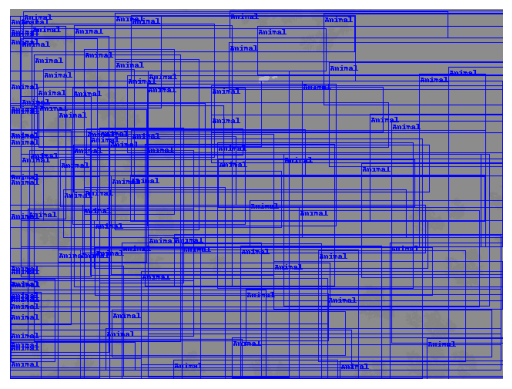

In [7]:
# Testeamos el tunned_model no entrenado
transforms = get_transform()

dataset = BIRDSAIDataset(TEST_DATA_PATH)
img, _ = dataset[0]
images = [transforms(d) for d in [img]]

model = get_tunned_model(3)
model_eval = model.eval()
outputs = model_eval(images)

# Mostramos el resultado
img_box = imgBoxes(img, outputs[0]["boxes"], outputs[0]["labels"])

fig = plt.figure()
ax = fig.add_subplot()
ax.axis('off')

ax.imshow(img_box)
plt.show()

## **Entrenamos el modelo**

In [ ]:
import torch
import torchvision

from UAVIR_tools.detection.engine import train_one_epoch
import UAVIR_tools.detection.utils as utils

train_real_dataset_imgs = 6000
train_sim_dataset_imgs = 6000
batch_size = 2
num_epochs = 10

# ------- MAIN --------- #
# Nuestro dataset tiene tres calses: 2 human, 1 animal, 0 background
num_classes = 3

# Definimos los dataset de train y test
dataset_real = BIRDSAIDataset(TRAIN_REAL_DATA_PATH, get_transform())
dataset_sim  = BIRDSAIDataset(TRAIN_SIM_DATA_PATH, get_transform())

# Generemos unos nuevos datasets basados en los originales, 
# pero más pequeños y randomizados
indices_real = torch.randperm(len(dataset_real)).tolist() 
dataset_real = torch.utils.data.Subset(dataset_real, indices_real[0:train_real_dataset_imgs])

indices_sim = torch.randperm(len(dataset_sim)).tolist() 
dataset_sim = torch.utils.data.Subset(dataset_sim, indices_sim[0:train_sim_dataset_imgs])

# Juntamos los dos datasets de entrenamiento
dataset = torch.utils.data.ConcatDataset([dataset_real, dataset_sim])

# Definimos el DataLoaders de entrenamiento
data_loader = torch.utils.data.DataLoader(
  dataset, batch_size=batch_size, shuffle=True, num_workers=4,
  collate_fn=utils.collate_fn)

# Generamos el modelo utilizando la función definida anteriormente
model = get_tunned_model(num_classes) 

# Guardamos el modelo en la RAM del dispositivo que estamos utilizando
model.to(device)
#model.load_state_dict(torch.load(os.path.join(OUTPUT_MODEL_PATH, "model_AUVIR_simTrain.pt")))

# Construimos un optimizador
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# y un learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

## Entrenamos para 'num_epochs' épocas ########################################
for epoch in range(num_epochs):
  # Ejecutanmos una época del entrenamiento, imprimiendo cada 10 iteraciones
  train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
  # Actualizamos el learning rate
  lr_scheduler.step()

# ¡Guardamos el modelo entrenado! ##############################################
createDir(OUTPUT_MODEL_PATH)
torch.save(model.state_dict(), os.path.join(OUTPUT_MODEL_PATH, "model_AUVIR_3080Ti.pt"))

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: [0]  [   0/3000]  eta: 2:50:49  lr: 0.000010  loss: 1.5777 (1.5777)  loss_classifier: 1.0782 (1.0782)  loss_box_reg: 0.3505 (0.3505)  loss_objectness: 0.1144 (0.1144)  loss_rpn_box_reg: 0.0346 (0.0346)  time: 3.4166  data: 0.6842  max mem: 4897
Epoch: [0]  [  10/3000]  eta: 1:07:18  lr: 0.000060  loss: 1.6979 (1.7195)  loss_classifier: 1.0300 (1.0011)  loss_box_reg: 0.3468 (0.2891)  loss_objectness: 0.2542 (0.3921)  loss_rpn_box_reg: 0.0391 (0.0372)  time: 1.3507  data: 0.0740  max mem: 5055
Epoch: [0]  [  20/3000]  eta: 1:02:15  lr: 0.000110  loss: 1.4080 (1.4034)  loss_classifier: 0.7805 (0.7802)  loss_box_reg: 0.3045 (0.2956)  loss_objectness: 0.1761 (0.2916)  loss_rpn_box_reg: 0.0348 (0.0360)  time: 1.1454  data: 0.0149  max mem: 5055
Epoch: [0]  [  30/3000]  eta: 1:00:38  lr: 0.000160  loss: 1.0089 (1.2593)  loss_classifier: 0.4063 (0.6398)  loss_box_reg: 0.3158 (0.3377)  loss_objectness: 0.0968 (0.2463)  loss_rpn_box_reg: 0.0242 (0.0355)  time: 1.1560  data: 0.0172  max me

KeyboardInterrupt: ignored

## Analizamos errores (TODO)

In [ ]:
# data_loader_test = torch.utils.data.DataLoader(
#   dataset_test, batch_size=1, shuffle=False, num_workers=4,
#   collate_fn=utils.collate_fn)